In [68]:
%matplotlib widget

import numpy as np
import torch
import matplotlib.pyplot as plt

In [69]:
t_domain = [0.0, 0.2]
x_domain = [-1.0, 1.0]

Nt = 6
Nx = 11

t = torch.linspace(t_domain[0], t_domain[1], Nt, requires_grad=True)
x = torch.linspace(x_domain[0], x_domain[1], Nx, requires_grad=True)

T, X = torch.meshgrid(t, x, indexing="ij")
T.shape, X.shape

(torch.Size([6, 11]), torch.Size([6, 11]))

In [70]:
# T and X contain the coordinates the Nt and Nx grid points, spanning the whole t and x domain;
# they are of shape (Nt, Nx); we can consider these the coordinates of the cell *boundaries*, and
# the cell centers are the midpoints between these coordinates
T_cell_centers = (T[:-1, :-1] + T[1:, :-1]) / 2
X_cell_centers = (X[:-1, :-1] + X[:-1, 1:]) / 2
T_cell_centers.shape, X_cell_centers.shape

(torch.Size([5, 10]), torch.Size([5, 10]))

In [71]:
# compute the width of each cell in the t and x directions
dT = T[1:, :-1] - T[:-1, :-1]
dX = X[:-1, 1:] - X[:-1, :-1]
dT.shape, dX.shape

(torch.Size([5, 10]), torch.Size([5, 10]))

In [72]:
# quadrature specification. 3 segment composite trapezoid
quad_pts = 4
xi = torch.linspace(-1, 1, quad_pts)
wi = torch.tensor([1.0] + [2.0 for _ in range(quad_pts - 2)] + [1.0])
wi = 2.0 * wi / sum(wi)

quad = {"t": (xi, wi), "x": (xi, wi)}
quad["t"][0], quad["t"][1], quad["x"][0], quad["x"][1]

(tensor([-1.0000, -0.3333,  0.3333,  1.0000]),
 tensor([0.3333, 0.6667, 0.6667, 0.3333]),
 tensor([-1.0000, -0.3333,  0.3333,  1.0000]),
 tensor([0.3333, 0.6667, 0.6667, 0.3333]))

In [73]:
F_t_eval_points = torch.zeros((Nt - 1, Nx - 1, 2 * quad_pts, 2))
F_x_eval_points = torch.zeros((Nt - 1, Nx - 1, 2 * quad_pts, 2))
F_t_quad_weights = torch.zeros((Nt - 1, Nx - 1, 2 * quad_pts))
F_x_quad_weights = torch.zeros((Nt - 1, Nx - 1, 2 * quad_pts))
#         (X_c + dX/2, T_c)
#     +-----------*----------+
#     |                      |
#     |                      |
#   x |       (X_c, T_c)     * (T_c + dT/2, X_c)
#     |                      |
#     |                      |
#     +----------------------+
#                 t
for i in range(Nt - 1):
    for j in range(Nx - 1):
        # calculate the cell center coordinates for cell i, j
        T_c = T_cell_centers[i, j]
        X_c = X_cell_centers[i, j]
        # we will evaluate F_t along the "right" and "left" edges of this cell
        # these are the t values corresponding the "right" edge of the cell; note they are all the same
        F_t_eval_points_t_p = (T_c + (dT[i, j] / 2.0)) * torch.ones(quad_pts)
        # similarly, these are the t values corresponding to the "left" edge of the cell
        F_t_eval_points_t_m = (T_c - (dT[i, j] / 2.0)) * torch.ones(quad_pts)
        # these are the x coordinates spanning the "right" edge of the cell
        F_t_eval_points_x_p = X_c + (dX[i, j] / 2.0) * quad["x"][0]
        # these are the x coordinates spanning the "left" edge of the cell
        F_t_eval_points_x_m = X_c - (dX[i, j] / 2.0) * quad["x"][0]
        # concatenate the "right" and "left" edge coordinates
        F_t_eval_points_t = torch.cat((F_t_eval_points_t_p, F_t_eval_points_t_m))
        F_t_eval_points_x = torch.cat((F_t_eval_points_x_p, F_t_eval_points_x_m))
        # store the results
        F_t_eval_points[i, j, :, 0] = F_t_eval_points_t
        F_t_eval_points[i, j, :, 1] = F_t_eval_points_x
        # concatenate the "right" and "left" edge weights; note the "left" edge weights are negative because
        # we are integrating in the opposite direction; also we normalize the weights here
        F_t_quad_weights[i, j, :] = torch.cat((quad["x"][1], -quad["x"][1])) / 2.0
        # the exact same procedure for the "top" and "bottom" edges of the cell
        F_x_eval_points_x_p = (X_c + (dX[i, j] / 2.0)) * torch.ones(quad_pts)
        F_x_eval_points_x_m = (X_c - (dX[i, j] / 2.0)) * torch.ones(quad_pts)
        F_x_eval_points_t_p = T_c + (dT[i, j] / 2.0) * quad["t"][0]
        F_x_eval_points_t_m = T_c - (dT[i, j] / 2.0) * quad["t"][0]
        F_x_eval_points_x = torch.cat((F_x_eval_points_x_p, F_x_eval_points_x_m))
        F_x_eval_points_t = torch.cat((F_x_eval_points_t_p, F_x_eval_points_t_m))
        F_x_eval_points[i, j, :, 0] = F_x_eval_points_t
        F_x_eval_points[i, j, :, 1] = F_x_eval_points_x
        F_x_quad_weights[i, j, :] = torch.cat((quad["t"][1], -quad["t"][1])) / 2.0

In [74]:
F_t_eval_points.shape, F_x_eval_points.shape, F_t_quad_weights.shape, F_x_quad_weights.shape

(torch.Size([5, 10, 8, 2]),
 torch.Size([5, 10, 8, 2]),
 torch.Size([5, 10, 8]),
 torch.Size([5, 10, 8]))

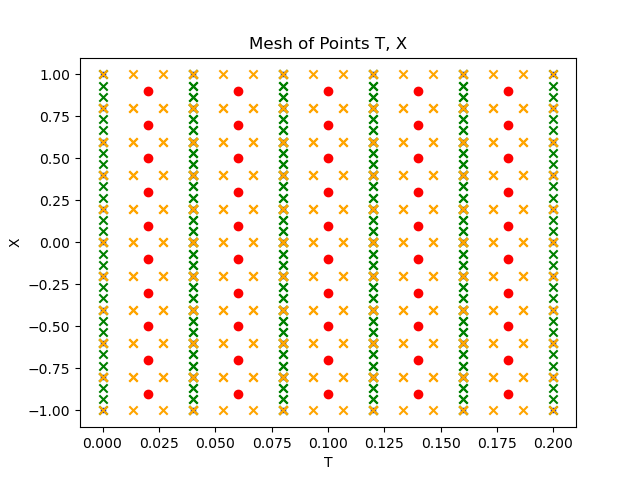

In [75]:
plt.figure()
plt.scatter(T.detach().flatten(), X.detach().flatten(), color="blue", marker=".")
# plt.errorbar(
#     T_cell_centers.detach().flatten(),
#     X_cell_centers.detach().flatten(),
#     xerr=dT.detach().flatten() / 2.0,
#     yerr=dX.detach().flatten() / 2.0,
#     color="black",
#     linestyle="",
#     capsize=3.0,
# )
plt.scatter(
    T_cell_centers.detach().flatten(),
    X_cell_centers.detach().flatten(),
    color="red",
    marker="o",
)
F_t_eval_points_t = F_t_eval_points[:, :, :, 0].detach().flatten()
F_t_eval_points_x = F_t_eval_points[:, :, :, 1].detach().flatten()
F_x_eval_points_t = F_x_eval_points[:, :, :, 0].detach().flatten()
F_x_eval_points_x = F_x_eval_points[:, :, :, 1].detach().flatten()
plt.scatter(F_t_eval_points_t, F_t_eval_points_x, color="green", marker="x")
plt.scatter(F_x_eval_points_t, F_x_eval_points_x, color="orange", marker="x")
plt.xlabel("T")
plt.ylabel("X")
plt.title("Mesh of Points T, X")
plt.show()

In [86]:
import cv_mesh
import importlib

importlib.reload(cv_mesh)


t_domain = [0.0, 0.2]
x_domain = [-1.0, 1.0]

Nt = 6
Nx = 11

cv_mesh = cv_mesh.CV_Mesh(t_domain, x_domain, Nt, Nx, None, quad_pts=(9, 9))
# get T, X, T_cell_centers, X_cell_centers, dT, dX, and all the F eval points
(
    T,
    X,
    T_cell_centers,
    X_cell_centers,
    dT,
    dX,
    F_t_eval_points,
    F_x_eval_points,
    F_t_quad_weights,
    F_x_quad_weights,
) = cv_mesh.get_mesh()

In [87]:
# write out the shapes of all the returned tensors
T.shape, X.shape, T_cell_centers.shape, X_cell_centers.shape, dT.shape, dX.shape, F_t_eval_points.shape, F_x_eval_points.shape, F_t_quad_weights.shape, F_x_quad_weights.shape

(torch.Size([6, 11]),
 torch.Size([6, 11]),
 torch.Size([5, 10]),
 torch.Size([5, 10]),
 torch.Size([5, 10]),
 torch.Size([5, 10]),
 torch.Size([5, 10, 18, 2]),
 torch.Size([5, 10, 18, 2]),
 torch.Size([5, 10, 18]),
 torch.Size([5, 10, 18]))

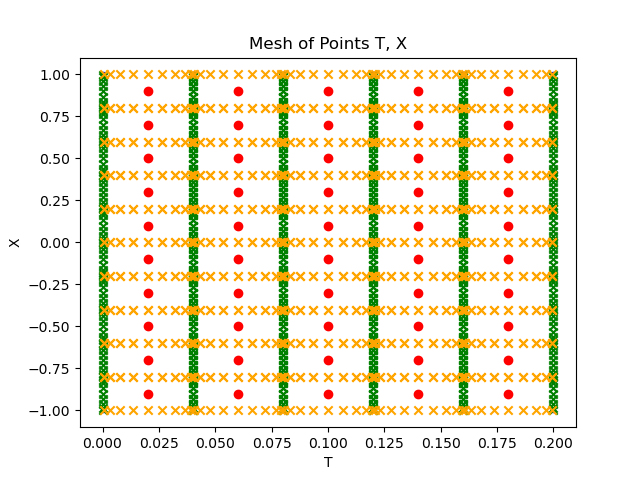

In [88]:
plt.figure()
plt.scatter(T.detach().flatten(), X.detach().flatten(), color="blue", marker=".")
# plt.errorbar(
#     T_cell_centers.detach().flatten(),
#     X_cell_centers.detach().flatten(),
#     xerr=dT.detach().flatten() / 2.0,
#     yerr=dX.detach().flatten() / 2.0,
#     color="black",
#     linestyle="",
#     capsize=3.0,
# )
plt.scatter(
    T_cell_centers.detach().flatten(),
    X_cell_centers.detach().flatten(),
    color="red",
    marker="o",
)
F_t_eval_points_t = F_t_eval_points[:, :, :, 0].detach().flatten()
F_t_eval_points_x = F_t_eval_points[:, :, :, 1].detach().flatten()
F_x_eval_points_t = F_x_eval_points[:, :, :, 0].detach().flatten()
F_x_eval_points_x = F_x_eval_points[:, :, :, 1].detach().flatten()
plt.scatter(F_t_eval_points_t, F_t_eval_points_x, color="green", marker="x")
plt.scatter(F_x_eval_points_t, F_x_eval_points_x, color="orange", marker="x")
plt.xlabel("T")
plt.ylabel("X")
plt.title("Mesh of Points T, X")
plt.show()